<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/gds_python/gds_python_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to get started with the Neo4j Graph Data Science Python client
## Learn the basic syntax of the newly released Python client for Neo4j Graph Data Science library

Data scientists like me love Python. It features a wide variety of machine learning and data science libraries that can help you get started on a data science project in minutes. It is not uncommon to use a variety of libraries in a data science workflow. With the release of version 2 of the Neo4j Graph Data Science (GDS) library, a supporting Python client has been introduced. The Python client for the GDS library is designed to help you seamlessly integrate the Neo4j Graph Data Science library into your data science workflow. Instead of having to write Cypher statements to execute graph algorithms, the Python client provides a simple surface that allows you to project and run graph algorithms using pure Python code.

Since the Python client for GDS is relatively new, there are not many examples out there yet. Therefore, I've decided to write this blog post to help you get started with the GDS Python client syntax and show some common usage patterns through a simple network analysis.

The Neo4j Graph Data Science Python client can be installed using the pip package installer.

In [3]:
!pip install graphdatascience

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 4.2 MB/s 
  Created wheel for neo4j: filename=neo4j-4.4.3-py3-none-any.whl size=116069 sha256=e584c4cc58da11643e870bba66ef91f98ab97513eb61833142d8d35568ad127b
  Stored in directory: /root/.cache/pip/wheels/db/dd/76/acacd519878f133f2f869aec70db548d89e04013209c3c62bc
Successfully built neo4j


An important thing to note is that the Python client is only guaranteed to work with GDS versions 2.0 and later. Therefore, if you have a previous version, I suggest you first upgrade the GDS library to the latest version.
# Neo4j environment setup
If you want to follow along with the code examples, you need to set up a Neo4j database. I suggest you use a [blank project on Neo4j Sandbox](https://sandbox.neo4j.com/?usecase=blank-sandbox) for this simple demonstration, but you can also download a [Neo4j Desktop application](https://neo4j.com/download/) and set up a local database.

Neo4j Sandbox has the GDS library already installed. However, if you use Neo4j Desktop, you have to install the GDS library manually.

# Setting up the GDS Python client connection
We start by defining the client connection to the Neo4j database. If you have seen any of my previous blog posts that use the official Neo4j Python driver, you can see that the syntax is almost identical.

In [4]:
from graphdatascience import GraphDataScience

host = "bolt://54.172.168.40:7687"
user = "neo4j"
password= "shares-masses-turnarounds"

gds = GraphDataScience(host, auth=(user, password))

We have instantiated the connection to the Neo4j instance. If you are using Neo4j Enterprise, you might have multiple databases available in Neo4j. If we want to use any database other than the default one, we can select the required database using the set_database  method.

In [25]:
# Optionally set different database
#gds.set_database("databaseName")

Lastly, we can verify that the connection is valid and the target Neo4j instance has the GDS library installed by using the `gds.version()` method.

In [26]:
# Check if connection is valid and the target database has GDS installed
print(gds.version())

2.0.1


The version() method should return the version of the installed GDS library. If it returns anything else, make sure that you entered the correct credentials and the GDS library is installed.
# Executing Cypher statements
The Python client allows you to execute arbitrary Cypher statements using the `run_cypher` method. The method takes two parameters are input. The first and mandatory parameter is the Cypher query you want to execute. The second method parameter is optional and can be used to provide any query parameters.

The `run_cypher` method can be used to import, transform, or fetch any data from the database. We will begin by populating the database with the [Harry Potter network](https://medium.com/neo4j/turn-a-harry-potter-book-into-a-knowledge-graph-ffc1c45afcc8) I created in one of my previous blog posts.

The network contains characters in the first book, and their interactions, which are represented as relationships. The CSV with the relationship is available on my GitHub, so we can use the `LOAD CSV` clause to retrieve the data from GitHub and store it into Neo4j.

In [27]:
query = """
LOAD CSV WITH HEADERS FROM $url AS row
MERGE (s:Character {name:row.source})
MERGE (t:Character {name:row.target})
MERGE (s)-[i:INTERACTS]->(t)
SET i.weight = toInteger(row.weight)
"""
params = {'url': 'https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/HP/hp_1.csv'}
gds.run_cypher(query, params)

""


The import script uses the `run_cypher` method to execute the Cypher statement used to import the Harry Potter network. To demonstrate how Cypher parameters work with the `run_cypher` method, I've attached the URL of the file as a Cypher parameter. While the Cypher query is represented as a string, the Cypher parameters are defined as a dictionary.
If you have done any data analysis in Python, you have probably used the Pandas library in your workflow. Therefore, when fetching data from a database using the run_cyphermethod, the method conveniently returns a populated Pandas DataFrame. Having the data available as a Pandas DataFrame makes it much easier to integrate the data from Neo4j into your analytical workflow and use it in combination with other libraries.

In this example, we will retrieve the degree (count of relationships) for each character in the network using the `run_cypher` method.

In [28]:
degree_df = gds.run_cypher("""
MATCH (c:Character)
RETURN c.name AS character,
       size((c)--()) AS degree
""")

degree_df.head()

,character,degree
0,Petunia Dursley,8
1,Dudley Dursley,14
2,Lily J. Potter,5
3,James Potter I,5
4,Harry Potter,83


Since the data is available as a Pandas DataFrame, we can easily integrate it into our analytical workflow. For example, we can use the Seaborn library to visualize the node degree distribution.

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(data=degree_df, x="degree", height=7, aspect=1.5)

NameError: ignored

We can easily observe that most nodes have less than 15 relationships. However, there is one outlier in the dataset with 83 connections, and that is, of course, Harry Potter himself.
# Projected graph object
The central concept of the GDS Python client is to allow projecting and executing graph algorithms in Neo4j with pure Python code. Furthermore, the Python client is designed to mimic the GDS Cypher procedures so that we don't have to learn a new syntax to use the Python client.

As you might know, before we can execute any graph algorithms, we first have to project an in-memory graph. For example, let's say we want to project a simple directed network of characters and their interactions with the Python client.

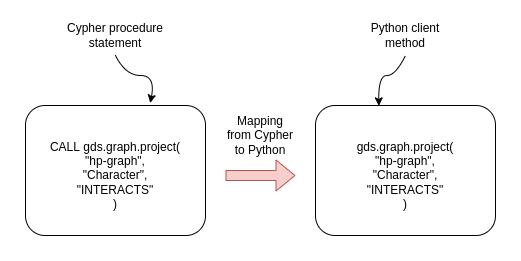

If you are familiar with Cypher procedures of the Graph Data Science library, you will be able to pick up the Python client syntax easily. For the most part, we remove the CALLclause before the GDS procedures, and we get the Python client syntax to project graphs or execute algorithms.

In our case, we want to project a network of characters where the interaction relationships are treated as undirected. Therefore, we must use the extended map syntax to define undirected relationships.

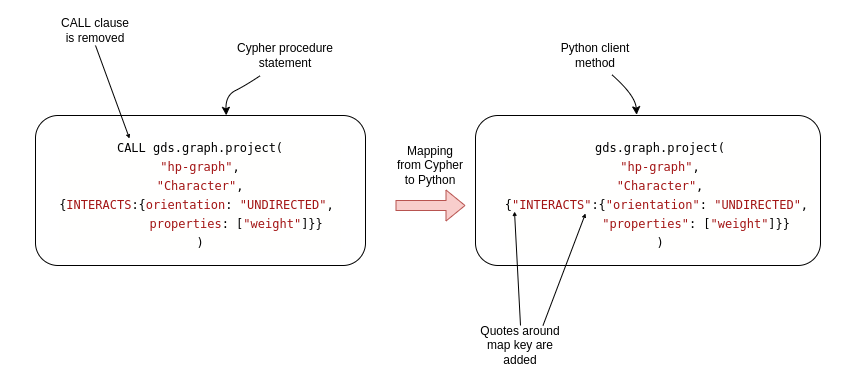

When dealing with map objects, or dictionaries as they are called in Python, we have to add quotes around map keys. Otherwise, the keys would be treated as variables in Python, and you would get a NameError as the key variables are not defined. So, apart from adding quotes and removing the CALLclause, the syntax to project an in-memory graph is identical. 

When projecting a graph with the Python client, a client-side reference to the projected graph is returned. We call these references Graph objects. Along with the Graph object, the metadata from the procedure call is returned as Pandas Series.


In [5]:
G, metadata = gds.graph.project(
    "hp-graph", 
    "Character",
    {"INTERACTS": {"orientation": "UNDIRECTED", "properties": ["weight"]}}
)

We have passed the projected graph reference to the `G` variable and stored the metadata information as the `metadata` variable. The metadata variable contains information that you normally get as the output of the procedure.

In [34]:
metadata

nodeProjection            {'Character': {'label': 'Character', 'properti...
relationshipProjection    {'INTERACTS': {'orientation': 'UNDIRECTED', 'a...
graphName                                                          hp-graph
nodeCount                                                               119
relationshipCount                                                       812
projectMillis                                                            53
Name: 0, dtype: object

There are 119 nodes and 812 relationships in our projected graph.
The Graph object, available as the variable G , has multiple method that can be used to inspect more information about the projected graph. For a complete list of the methods consult with the [official documentation](https://neo4j.com/docs/graph-data-science/current/python-client/graph-object/#_inspecting_a_graph_object).

For example, we can return the projected graph name using the `name()` method, inspect the memory usage using the `memory_usage()` method, or even calculate the density of the graph using the `density()` method.

In [38]:
print(G.name())
print(G.memory_usage())
print(G.density())

hp-graph
2341 KiB
0.05782652043868395


# Running graph algorithms
Now that we have the projected graph ready and available as the reference variable `G` , we can go ahead and execute a couple of graph algorithms using the Python client.

We will begin by executing the weighted variant of the PageRank algorithm. The `stream` mode of the algorithm returns the result of the algorithm as a stream of records.

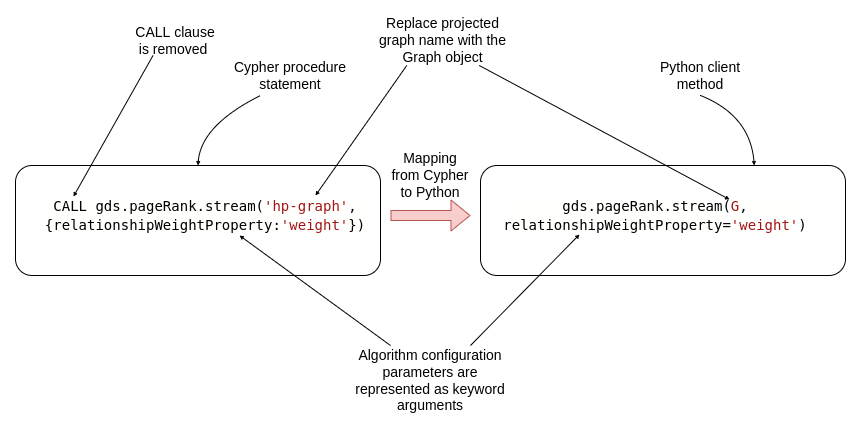

Similar to before, when we were projecting an in-memory graph, we need to remove the `CALL` clause in the Python client for all algorithm executions. We reference the projected graph by its name with the Cypher procedure statement. However, using the Python client, we pass the Graph object as the reference to the projected in-memory graph instead of its name. Lastly, any algorithm configuration parameters can be specified as keyword arguments in the Python client.
We can use the following Python script to execute the `stream` mode of the weighted PageRank algorithm.

In [6]:
# PageRank stream
pagerank_df = gds.pageRank.stream(G, relationshipWeightProperty="weight")
pagerank_df.head()

,nodeId,score
0,0,1.851142
1,1,3.241780
2,2,0.375610
3,3,0.375610
4,4,24.197442


The `stream` mode of any algorithm in the GDS library returns a stream of records. Python client then automatically converts the output into a Pandas DataFrame.

If you have ever executed the `stream` mode of the graph algorithms in Neo4j GDS library, you might be aware that the result contains internal node ids as a reference to nodes instead of actual node objects. The `pagerank_df` DataFrame contains two columns:
* nodeId: Internal node ids used to reference nodes
* score: PageRank score

We can retrieve the referenced node objects using the `nodeId` column without constructing a Cypher statement by using the `gds.util.asNodes()` method. The `gds.util.asNodes()` method takes a list of internal node ids as input and outputs a list of node objects.

In [7]:
# If you need to fetch information about node objects based on their internal node ids, you can use gds.util.asNodes
pagerank_df['node_object'] =  gds.util.asNodes(pagerank_df['nodeId'].to_list())

The `node_object` column now contains the referenced node objects. Node objects are defined in the underlying Neo4j Python driver. You can reference the [official documentation if you want to examine all the possible methods of the node object](https://neo4j.com/docs/api/python-driver/current/api.html#node).

In this example, we will extract the `name` property from node objects and then visualize a bar chart of the top ten characters with the highest PageRank score.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

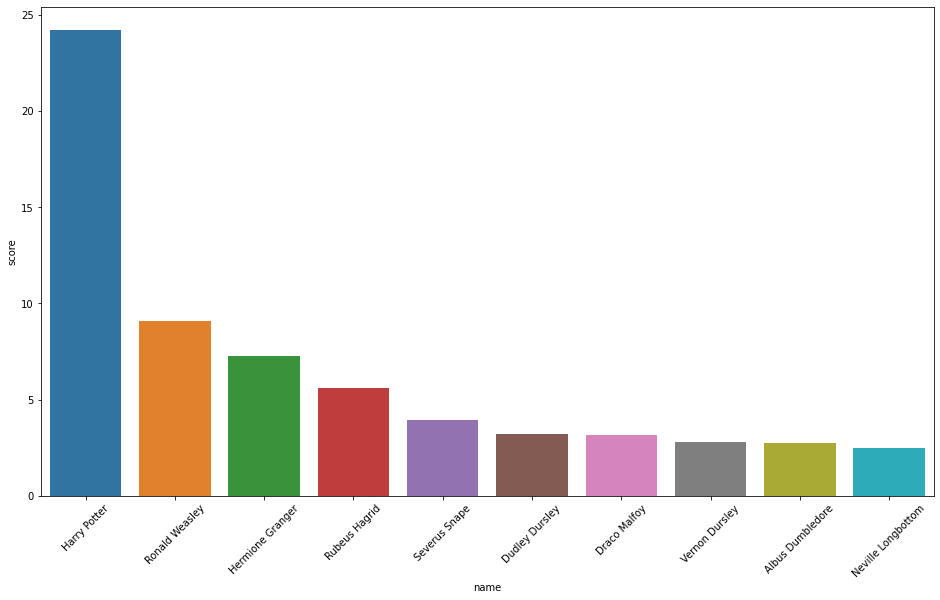

In [10]:
# Extract name properties from the node object
pagerank_df['name'] = [n['name'] for n in pagerank_df['node_object']]
# Draw a bar chart
plt.figure(figsize=(16,9))
sns.barplot(x='name', y='score', data=pagerank_df.sort_values(by='score', ascending=False).head(10))
plt.xticks(rotation=45)


An additional benefit of having the graph algorithm output available in the Pandas Dataframe is that if you are not experienced with Cypher aggregations, you can simply skip them and do your aggregations in Pandas.

As opposed to the `stream` mode of algorithms, the `stats`, `mutate`, and `write` modes do not produce a stream of results. Therefore, the results of Python client methods are not Pandas DataFrame. Instead, those methods output the algorithm metadata in Pandas Series format.

For example, let's say we want to execute the mutate mode of the Louvain algorithm.

In [13]:
# Louvain mutate
louvain_metadata = gds.louvain.mutate(G, mutateProperty='communityId', relationshipWeightProperty='weight')
print(louvain_metadata)

mutateMillis                                                             0
nodePropertiesWritten                                                  119
modularity                                                        0.176974
modularities                    [0.15405649883268652, 0.17697414179849225]
ranLevels                                                                2
communityCount                                                          10
communityDistribution    {'p99': 42, 'min': 2, 'max': 42, 'mean': 11.9,...
postProcessingMillis                                                     3
preProcessingMillis                                                      0
computeMillis                                                         1431
configuration            {'maxIterations': 10, 'seedProperty': None, 'c...
Name: 0, dtype: object


The mapping from Cypher to Python is identical as in the PageRank example. The Graph object replaces the name of the projected graph, and additional algorithm configuration parameters are specified using the keyword arguments.

We can observe that the algorithm identified ten communities, while the modularity score is relatively low.

The `mutate` mode of the algorithm stores the results in the projected in-memory graph. One of the Graph object methods is the `node_properties()` method, which can be used to inspect which node properties are present in the in-memory graph.

In [ ]:
G.node_properties('Character')

['communityId']

The result of the `node_properties()` method verifies that the communityId node property was added to the projected graph. 

Sometimes we want to retrieve the node properties from the projected in-memory graph. Luckily, there is a `gds.graph.streamNodeProperty()` method that fetches node properties from the projected in-memory graph and outputs them as a Pandas DataFrame.

In [14]:
# If you want to retrieve node properties from the in-memory graph in the form of a Pandas DataFrame
louvain_df = gds.graph.streamNodeProperty(G, 'communityId')
louvain_df.head()

,nodeId,propertyValue
0,0,103
1,1,103
2,2,3
3,3,3
4,4,14


The first parameter of the `gds.graph.streamNodeProperty()` method is the referenced Graph object. As the second parameter, we define which property we want to retrieve from the in-memory graph.

Again, we get the internal node ids in the `nodeId` column. We could use the `gds.util.asNodes()` method to fetch the node objects that the internal node ids reference. Unfortunately, the column with the retrieved node properties has a generic name `propertyValue` . In our case, it would make sense to name the column with the results `communityId` . However, we can do that manually if we need to.

In [15]:
# Rename columns
louvain_df.columns = ['nodeId', 'communityId']
# You can do all sorts of pandas operations like aggregations
louvain_df.groupby("communityId").size().to_frame(
    "communitySize"
).reset_index().sort_values(by=["communitySize"], ascending=False)

,communityId,communitySize
2,14,42
8,103,18
7,99,16
5,69,11
3,31,8
1,4,7
4,48,6
6,81,5
9,117,4
0,3,2


Like mentioned before, the added benefit of dealing with Pandas DataFrames as algorithm output is that you can apply all your Python skills to transform or manipulate the results. In this example, we simply grouped the DataFrame by the `communityId` column and count the members of each community.

# Helpful methods
In the last part of this post, we will go over some of the helpful methods. The first one that comes to mind is listing all of the already projected in-memory graph with the `gds.graph.list()` method.

In [18]:
gds.graph.list()

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,"{'p99': 41, 'min': 1, 'max': 83, 'mean': 6.823...",hp-graph,neo4j,2366 KiB,2423504,119,812,{'relationshipProjection': {'INTERACTS': {'ori...,0.057827,2022-05-31T16:09:01.093499000+00:00,2022-05-31T16:28:38.728160000+00:00,{'relationships': {'INTERACTS': {'weight': 'Fl...


Sometimes there are already projected in-memory graphs present in the database. If you don't have a reference to the projected graphs in the form of a Graph object, you cannot execute any graph algorithm. To avoid having to drop and recreate projected graphs, you can use the `gds.graph.get()` method.

In [ ]:
# G = gds.graph.get("graph name")

When using the shortest path algorithms, you need to provide source and target nodes ids. You could use Cypher statements or you could use the `gds.find_node_id()` method.

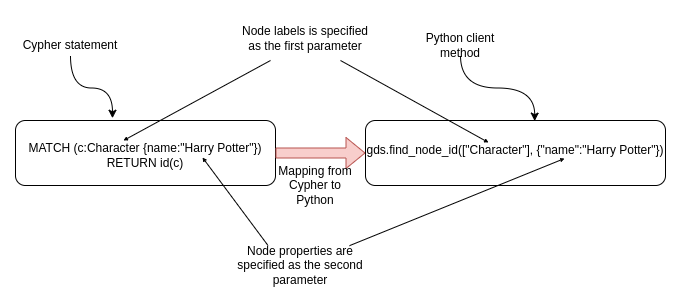

The `gds.find_node_id()` takes in two arguments. The first argument defines the node label we are searching for. In our example, we are searching for the `Character` node label. The second parameter specifies the node properties used to identify the particular node. The node properties are defined as a dictionary or map of key-value pairs, similar to the inline `MATCH` clause. The only difference is that we must add quotes around the key values of properties since otherwise, we would get a NameError in Python.

In [22]:
gds.find_node_id(["Character"], {"name":"Harry Potter"})

4

The last useful method I will present here is the `drop()` method of a Graph object. It is used to release the projected graph from memory.

In [ ]:
# Drop a projected in-memory graph
G.drop()

# Conclusion
The Neo4j Graph Data Science Python client is designed to help you integrate Neo4j and its graph algorithms into your Python analytical workflows. The syntax of the Python client mimics the GDS Cypher procedures. Since not all graph algorithms are documented to be used as Python client method, you need to take into account the following guidelines when translating a Cypher procedure to a Python client method:
* When specifying a map or a dictionary as a parameter to any method, make sure to add quotes around the keys
* Instead of referencing the projected graph by its name, you need to input the * Graph object as the first parameter of graph algorithms
* Algorithm specific configuration parameter can be specified using keyword arguments
* The stream mode of graph algorithms outputs a Pandas DataFrame
* Other algorithm modes like stats , write , and mutate output the metadata of the algorithm call as a Pandas Series

I am very excited about the new Python client and will be definitely using it in my workflows. Try it out and if you have any feedback please report it to the [official GitHub repository of the Python client](https://github.com/neo4j/graph-data-science-client).